# <center> RNN: Text Classification (sentiment)

**Case Description**

Text Sentiment classification is the automated process of identifying and classifying emotions in text as positive sentiment, negative sentiment, or neutral sentiment based on the opinions expressed within. It helps determine the nature and extent of feelings conveyed using Natural Language Processing (NLP) to understand what people say or feel about different cases.

*Business case: you have e-commerce shop and there are a lot of customers' feedback. If you know how to work with this type of information based on Machine Learning algorithms or Deep Learning methods. It helps you to understand what your customers say and feel about brand, products, and services and how you can influence on it in positive way*

**Task**
* Using the data to build a model that predicts text sentiment

**Data**: There are 3 files: *Train* and *test* csv files + *sample_submission*.
* Train dataset contains 2 columns and more than 41k rows:
    - *Text* description
    - *Sentiment* (5 types)
* Test dataset also contains 2 columns and ~ 3,8k rows
    - *id* number,
    - *Text* description
* Sample submission file as an example of the final file contains *id* number of Test data and predicted *Sentiment* value

**ML/DL task**: Classify texts with RNN (Recurrent Neural Networks)

**Loss**: Categorical crossentropy

**Metrics**: Accuracy

**Project Limitations**: it is allowed to use any text vectorization technique (except of Transformers) and any variants of RNN models.

*Training on GPU*

# 0. Install and Import

In [1]:
%%capture

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re #regular expression
import random
# Libs for Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter
from itertools import cycle

# Text preprocessing
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find("wordnet.zip")
except:
    nltk.download("wordnet", download_dir="/kaggle/working/")
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append("/kaggle/working/")
    
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords #list of lexical stop words
nltk.download("stopwords")

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Embedding, Dense, Dropout, SpatialDropout1D #Flatten,
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.backend import clear_session

import warnings
warnings.filterwarnings("ignore")

Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.noun  
  inflating: /kaggle/working/corpora/wordnet/data.adv  


2024-03-25 11:09:50.563825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 11:09:50.563937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 11:09:50.864865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Fixing RANDOM_SEED to make experiment repetable
RANDOM_SEED = 42

# Set random seeds
def set_seed(seed):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
    
set_seed(RANDOM_SEED)

In [3]:
# Fixing package versions to make experiment repetable
!pip freeze > requirements.txt

# 1. Data Loading: dataset exploration

In [4]:
# Reading dataset's file
DATA_DIR = "/kaggle/input/nlp-txt-classification"

train_data = pd.read_csv(DATA_DIR+"/train.csv", index_col=0)
test_data = pd.read_csv(DATA_DIR+"/test.csv")
sample_submission = pd.read_csv(DATA_DIR+"/sample_submission.csv")

print("Train data:\n")
display(train_data.head())
print(f"Train dataset`s shape: {train_data.shape}")

print("\nTest data:\n")
display(test_data.head())
print(f"Test dataset`s shape: {test_data.shape}")

print("\nSample submission:\n")
display(sample_submission.head())
print(f"Sample submission size: {sample_submission.shape}")

Train data:



,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Train dataset`s shape: (41159, 2)

Test data:



,id,Text
0,787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING: New Yorkers encounter empty supermar...
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldn't find hand sanitizer at Fred Me...
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,#Panic buying hits #NewYork City as anxious sh...
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,#toiletpaper #dunnypaper #coronavirus #coronav...


Test dataset`s shape: (3798, 2)

Sample submission:



,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Neutral
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Neutral
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Neutral
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Neutral
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


Sample submission size: (3798, 2)


In [5]:
sample_submission.Sentiment.value_counts()

Sentiment
Neutral    3798
Name: count, dtype: int64

**Some observations based on the dataset view:**
* Train dataset's shape: 41159 rows, 2 columns
    - *Text* and *Sentiment*
* Test dataset's shape: 3798 rows, 2 columns
    - *id* and *Text*
* Sample submission file is used as example of final result for test dataset.

In [6]:
"""
Let's check Missing Values (MV)
If there are not a lof of MV examples -> I can delete them
"""
print(f"Features with missing values (train): {train_data.isnull().sum()}")
print(f"\nFeatures with missing values (test): {test_data.isnull().sum().sum()}")

Features with missing values (train): Text         1
Sentiment    4
dtype: int64

Features with missing values (test): 0


In [7]:
train_data = train_data.dropna()

print(f"Features with missing values (train): {train_data.isnull().sum().sum()}")
print(f"Train dataset's shape: {train_data.shape}")

Features with missing values (train): 0
Train dataset's shape: (41155, 2)


Sentiment
Positive              0.277536
Negative              0.240967
Neutral               0.187365
Extremely Positive    0.160952
Extremely Negative    0.133179
Name: proportion, dtype: float64

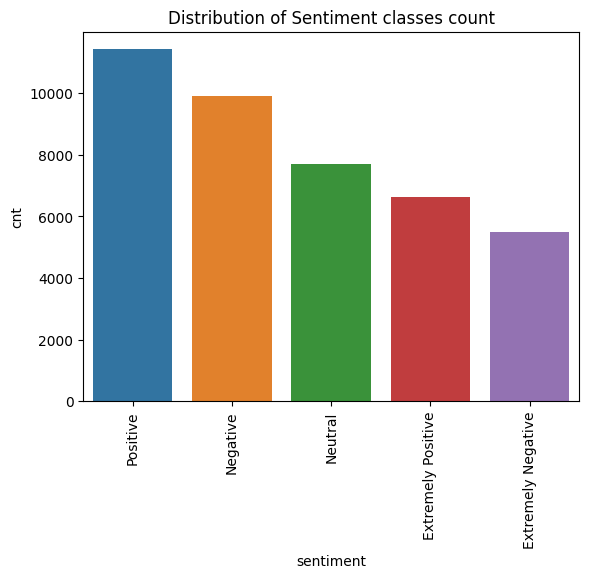

In [8]:
"""
Train data

Let's look at the Sentiment classes' distribution
"""
display(train_data["Sentiment"].value_counts(normalize=True))
sentiment_var = train_data["Sentiment"].value_counts().reset_index()
sentiment_var.columns = ["sentiment", "cnt"]

# Distribution of classes_count
sns.barplot(x="sentiment", y="cnt", data=sentiment_var)
plt.title("Distribution of Sentiment classes count")
plt.xticks(rotation=90)
plt.show()

**Some observations:**
* The most popular sentiment is *Positive* and the least is *Extremely Negative*.
    - Positive: ~28%
    - Negative: ~24%
    - Neutral: ~19%
    - Extremely Positive: ~16%
    - Extremely Negative: ~13%
    
The most common class is twice as large as the rarest.

In [9]:
# Let's look at some examples
print(train_data["Text"].iloc[0])
print(train_data["Text"].iloc[100])

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
I hate grocery shopping in general but I swear IÂm doing it online next shop, can not deal with the swathes of panic buyers at all! #COVID?19 #coronavirus #coronavirusuk #anxiety #panicbuyinguk #morons


**Some observations:**

* Description text has uppercase and lowercase letters
* Text contains special symbols (@, #) and url-address

During Text preprocessing we need to solve these points if it has a sense

In [10]:
# Let's make a copy of the given DataFrame in order to protect original DF
df_temp = train_data.reset_index().copy()
df_temp = df_temp.drop("index", axis=1)

df_temp

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41150,Airline pilots offering to stock supermarket s...,Neutral
41151,Response to complaint not provided citing COVI...,Extremely Negative
41152,You know itÂs getting tough when @KameronWild...,Positive
41153,Is it wrong that the smell of hand sanitizer i...,Neutral


# 2.1 Text preprocessing

Text preprocessing is the practice of cleaning and preparing text data. This is one of the most crucial steps in the process.

Using NLTK, text information are then pre-processed with the following:

* tokenization — convert sentences to words
* converting the text to lower case
* stopwords removal - frequent words which have not any semantic sense
* removing punctuation, numerical values, some extra examples
* lemmatization - convert the word into a root word

At every stage is necessary go through the text manually to try "catch" examples which can definitely show up and hurt the model.

In [11]:
def text_preprocessing(data):
    """
    - Remove text from URL strings
    - Splitting the text into separate words (token) by capital letter
    (! Be careful with regex in order to save correct version of words writting by capslock)
    - Converting all the characeters to lower case
    """
    to_match = ["http\S+", "@", "#"]
    
    data["text_no_url"] = data["Text"].apply(lambda x: re.sub("|".join(to_match), " ", str(x)))
    data["token"] = data["text_no_url"].apply(lambda x: re.sub( r"([A-Z][^a-z]*)", r" \1", x))
    data["text_lower"] = data["token"].str.lower()
    
    return data

In [12]:
"""
Text preprocessing:
- delete special symbols and URLs
- get tokens (separate words)
- convert tokens to lower case
"""
df_temp = text_preprocessing(df_temp)

In [13]:
df_temp.head(2)

,Text,Sentiment,text_no_url,token,text_lower
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,MeNyrbie Phil_Gahan Chrisitv and and,Me Nyrbie Phil_ Gahan Chrisitv and a...,me nyrbie phil_ gahan chrisitv and a...
1,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...,advice Talk to your neighbours family to exch...,advice talk to your neighbours family to exch...


# 2.2 Text preprocessing: Lemmatization

In [14]:
"""
Lemmatization
which will return the base form or lemma
"""
wnl = WordNetLemmatizer()
patterns = "[^a-zA-Z \n\.]"

# Use stopwords list from nltk
stopwords_eng = stopwords.words("english")

# Look at the base stopwords list
print(f"Base stopwords list:{stopwords_eng}")

# add extra stopwords
stopwords_eng.extend(["."])


def lemmatize_sentence(text):
    text = re.sub(patterns, " ", text)
    tokens = []
    
    for token in text.split():
        if token and token not in stopwords_eng:
            token = token.strip()
            token = wnl.lemmatize(token)
            
#             if len(token) == 1: continue #delete "." after removing numerical symbol (4.6 oz)
#             else:
            tokens.append(token)
            
    return " ".join(tokens) # back to string from list

Base stopwords list:['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'sa

In [15]:
print("Full text description before text_preprocessing:\n", df_temp["Text"].iloc[100])
print("\nBefore lemmatization:\n", df_temp["text_lower"].iloc[100])
print("\nAfter lemmatization:\n", lemmatize_sentence(df_temp["text_lower"].iloc[100]))

Full text description before text_preprocessing:
 I hate grocery shopping in general but I swear IÂm doing it online next shop, can not deal with the swathes of panic buyers at all! #COVID?19 #coronavirus #coronavirusuk #anxiety #panicbuyinguk #morons

Before lemmatization:
  i hate grocery shopping in general but  i swear  iâm doing it online next shop, can not deal with the swathes of panic buyers at all!   covid?19  coronavirus  coronavirusuk  anxiety  panicbuyinguk  morons

After lemmatization:
 hate grocery shopping general swear online next shop deal swathe panic buyer covid coronavirus coronavirusuk anxiety panicbuyinguk moron


In [16]:
# Get new column with lemmatize text
df_temp["full_desc_lem"] = df_temp["text_lower"].apply(lemmatize_sentence)
df_temp.head(2)

,Text,Sentiment,text_no_url,token,text_lower,full_desc_lem
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,MeNyrbie Phil_Gahan Chrisitv and and,Me Nyrbie Phil_ Gahan Chrisitv and a...,me nyrbie phil_ gahan chrisitv and a...,nyrbie phil gahan chrisitv
1,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...,advice Talk to your neighbours family to exch...,advice talk to your neighbours family to exch...,advice talk neighbour family exchange phone nu...


In [17]:
# Update token_number_after_lem column
df_temp["token_number_after_lem"] = [len(word.split()) for word in df_temp["full_desc_lem"]]
df_temp.head()

,Text,Sentiment,text_no_url,token,text_lower,full_desc_lem,token_number_after_lem
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,MeNyrbie Phil_Gahan Chrisitv and and,Me Nyrbie Phil_ Gahan Chrisitv and a...,me nyrbie phil_ gahan chrisitv and a...,nyrbie phil gahan chrisitv,4
1,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...,advice Talk to your neighbours family to exch...,advice talk to your neighbours family to exch...,advice talk neighbour family exchange phone nu...,27
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths to give elde...,Coronavirus Australia: Woolworths to give e...,coronavirus australia: woolworths to give e...,coronavirus australia woolworth give elderly d...,12
3,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...,My food stock is not the only one which is em...,my food stock is not the only one which is em...,food stock one empty... please panic enough fo...,24
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"Me, ready to go at supermarket during the COV...","Me, ready to go at supermarket during the C...","me, ready to go at supermarket during the c...",ready go supermarket covid outbreak. paranoid ...,23


# 2.3 Text preprocessing: Descriptive statistics for word count
In text analysis, descriptive statistics play a crucial role in summarizing and understanding the characteristics of textual data.

* min/ max/ mean number of words in text description,
* the most popular and rare words,
* popular part of speech

In [18]:
df_temp["token_number_after_lem"].describe()

count    41155.000000
mean        18.775386
std          6.935350
min          0.000000
25%         13.000000
50%         19.000000
75%         24.000000
max         47.000000
Name: token_number_after_lem, dtype: float64

**Some observations based on the data:**
* min number of words in text description: 0
* max number of words in text description: 47

It's strange that we have text rows with 0 number of words. Let's check it.

In [19]:
display(df_temp[df_temp["token_number_after_lem"] == 0])
print("\n Total number of examples with 0 count in words count:", format(df_temp[df_temp["token_number_after_lem"] == 0]["Sentiment"].count()))

,Text,Sentiment,text_no_url,token,text_lower,full_desc_lem,token_number_after_lem
16,????? ????? ????? ????? ??\r\r\n?????? ????? ?...,Neutral,????? ????? ????? ????? ??\r\r\n?????? ????? ?...,????? ????? ????? ????? ??\r\r\n?????? ????? ?...,????? ????? ????? ????? ??\r\r\n?????? ????? ?...,,0
2385,?? ??? ???. ????????-????? ?????? 3 ??????????...,Neutral,?? ??? ???. ????????-????? ?????? 3 ??????????...,?? ??? ???. ????????-????? ?????? 3 ??????????...,?? ??? ???. ????????-????? ?????? 3 ??????????...,,0
5214,???? ???????? ??????????? - ???????? ?????????...,Neutral,???? ???????? ??????????? - ???????? ?????????...,???? ???????? ??????????? - ???????? ?????????...,???? ???????? ??????????? - ???????? ?????????...,,0
8841,????? ? ????? ?? ?????: ??????????? ??? ?? ???...,Neutral,????? ? ????? ?? ?????: ??????????? ??? ?? ???...,????? ? ????? ?? ?????: ??????????? ??? ?? ???...,????? ? ????? ?? ?????: ??????????? ??? ?? ???...,,0
12410,This is why we 19,Neutral,This is why we 19,This is why we 19,this is why we 19,,0
13843,? ???? ????? ???? ??? ?????? ??? ???\r\r\n\r\r...,Neutral,? ???? ????? ???? ??? ?????? ??? ???\r\r\n\r\r...,? ???? ????? ???? ??? ?????? ??? ???\r\r\n\r\r...,? ???? ????? ???? ??? ?????? ??? ???\r\r\n\r\r...,,0
14840,???? ??????? ??????? ????? ??? ?????? ??????? ...,Neutral,???? ??????? ??????? ????? ??? ?????? ??????? ...,???? ??????? ??????? ????? ??? ?????? ??????? ...,???? ??????? ??????? ????? ??? ?????? ??????? ...,,0
16920,???? ??????? ??????? ???? ????? ???? ???? ????...,Neutral,???? ??????? ??????? ???? ????? ???? ???? ????...,???? ??????? ??????? ???? ????? ???? ???? ????...,???? ??????? ??????? ???? ????? ???? ???? ????...,,0
16924,????? ?\r\r\n\r\r\n???? ??? ???? ??? ?????????...,Neutral,????? ?\r\r\n\r\r\n???? ??? ???? ??? ?????????...,????? ?\r\r\n\r\r\n???? ??? ???? ??? ?????????...,????? ?\r\r\n\r\r\n???? ??? ???? ??? ?????????...,,0
18437,????? ?? ??????? ?? ??????? ???? ???? ????????...,Neutral,????? ?? ??????? ?? ??????? ???? ???? ????????...,????? ?? ??????? ?? ??????? ???? ???? ????????...,????? ?? ??????? ?? ??????? ???? ???? ????????...,,0



 Total number of examples with 0 count in words count: 13


**Some observations:**
* Most of the examples include only special symbols. I guess, the reason of symbols instead of the text is bug with Unicode.

-> At this stage it's possible to delete these examples because they are not a lot of.

In [20]:
df_temp = df_temp[df_temp["token_number_after_lem"] > 0]
df_temp.shape

(41142, 7)

In [21]:
df_temp = df_temp.reset_index().drop("index", axis=1).copy()
df_temp

,Text,Sentiment,text_no_url,token,text_lower,full_desc_lem,token_number_after_lem
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,MeNyrbie Phil_Gahan Chrisitv and and,Me Nyrbie Phil_ Gahan Chrisitv and a...,me nyrbie phil_ gahan chrisitv and a...,nyrbie phil gahan chrisitv,4
1,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...,advice Talk to your neighbours family to exch...,advice talk to your neighbours family to exch...,advice talk neighbour family exchange phone nu...,27
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths to give elde...,Coronavirus Australia: Woolworths to give e...,coronavirus australia: woolworths to give e...,coronavirus australia woolworth give elderly d...,12
3,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...,My food stock is not the only one which is em...,my food stock is not the only one which is em...,food stock one empty... please panic enough fo...,24
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"Me, ready to go at supermarket during the COV...","Me, ready to go at supermarket during the C...","me, ready to go at supermarket during the c...",ready go supermarket covid outbreak. paranoid ...,23
...,...,...,...,...,...,...,...
41137,Airline pilots offering to stock supermarket s...,Neutral,Airline pilots offering to stock supermarket s...,Airline pilots offering to stock supermarket ...,airline pilots offering to stock supermarket ...,airline pilot offering stock supermarket shelf...,9
41138,Response to complaint not provided citing COVI...,Extremely Negative,Response to complaint not provided citing COVI...,Response to complaint not provided citing CO...,response to complaint not provided citing co...,response complaint provided citing covid relat...,16
41139,You know itÂs getting tough when @KameronWild...,Positive,You know itÂs getting tough when KameronWild...,You know itÂs getting tough when Kameron W...,you know itâs getting tough when kameron w...,know getting tough kameron wild rationing toil...,14
41140,Is it wrong that the smell of hand sanitizer i...,Neutral,Is it wrong that the smell of hand sanitizer i...,Is it wrong that the smell of hand sanitizer ...,is it wrong that the smell of hand sanitizer ...,wrong smell hand sanitizer starting turn coron...,9


***

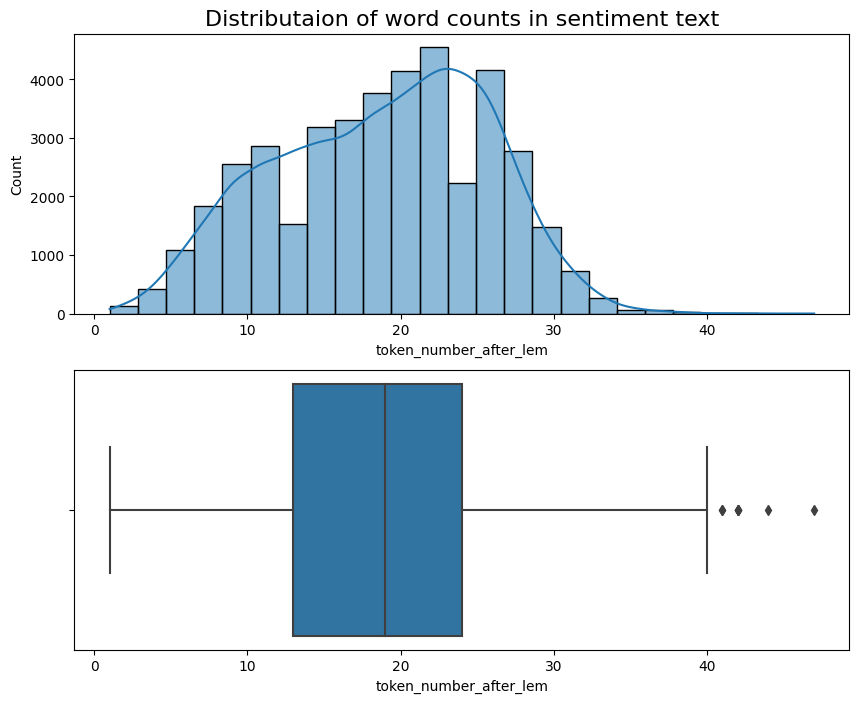

In [22]:
"""
Checking the distribution character of word counts
"""
# Data visualisation: histogram and boxplot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

histplot = sns.histplot(
    data=df_temp,
    x="token_number_after_lem",
    bins=25,
    kde=True,
    ax=axes[0]);
histplot.set_title("Distributaion of word counts in sentiment text", fontsize=16);

boxplot = sns.boxplot(
    data=df_temp,
    x="token_number_after_lem",
    orient="h",
    width=0.9,
    ax=axes[1]);

**Some observations:**
* The data is close to normally distributed. But anyway there are outliers: 4 examples with more than 40 words in text description

In [23]:
"""
Look in details of example with more than 40 word counts
"""
df_temp[df_temp["token_number_after_lem"] > 40]["full_desc_lem"].iloc[:]

1637     z sah policie proti spekulant rou kami. na j p...
7597     domino fall coronavirus gt world healthemergen...
8371     wake up. news on. breakfast. school run. daily...
9023     la escena se repite alrededor del mundo desde ...
13686    hoy aplaudo mi segunda familia aplaudo anuestr...
16625    bir ddettir permarketlerin lojistik hizmeti av...
21429    u oil rig drop hugely dallas fed energy survey...
37142    nisan cumartesi itibariyle bb nin hizmetleri s...
Name: full_desc_lem, dtype: object

In our case if we calculate The Interquartile Range (IQR) (Q3 - Q1) - the middle 50% (19) of the data consists of text description word counts around 11 (Q3 = 24, Q1 = 13). It has a sense to remove examples with less than 6 word counts and more than 37 (1.5 * IQR =~17) based on this calculation result.

Based on the Descriptive statistics we know that the minimum value of word counts in text description is 0.

Let's look at these examples.

In [24]:
# Check the number of examples with more than 37 word counts
number_of_examples = df_temp.shape[0]
high_word_counts = len(df_temp[df_temp["token_number_after_lem"] > 37])

print(f"Total number of examples in dataset:\n {number_of_examples}")
print(f"\nNumber of examples with more than 37 word counts: \
{round(high_word_counts * 100 / number_of_examples, 2)}% \n {high_word_counts}")

print("")
display(df_temp[df_temp["token_number_after_lem"] > 37]["full_desc_lem"].iloc[1])

Total number of examples in dataset:
 41142

Number of examples with more than 37 word counts: 0.09% 
 36



'consequence stock market crash short term credit dry up. employer money pay worker buy inventory pay supplier bankruptcy gt layoff gt demand fall gt consumption end traumatic damage civil war dow jones sp usa trump coronavirus sick depression'

In [25]:
# Check the number of examples with less than 3 word counts
number_of_examples = df_temp.shape[0]
low_word_counts = len(df_temp[df_temp["token_number_after_lem"] < 3])

print(f"Total number of examples in dataset:\n {number_of_examples}")
print(f"\nNumber of examples with less than 3 word counts: \
{round(low_word_counts * 100 / number_of_examples, 2)}% \n {low_word_counts}")

print("")
display(df_temp[df_temp["token_number_after_lem"] < 3]["full_desc_lem"].iloc[1])

Total number of examples in dataset:
 41142

Number of examples with less than 3 word counts: 0.3% 
 124



'kind'

**Some observations:**
* The examples of descriptions with word count more than 37 is about 0.09% - 36 rows.
* The examples of descriptions with word count less than 3 is about 0.3% - 124 rows.

Usually we can delete these examples, but I want to save all of them for furter investigation because most of these examples in English.

In [26]:
"""
Get the top 5 most common words among all the text descriptions
"""

def most_common_words(df_temp, sentiment):
    p_text = [word.split() for word in df_temp[df_temp["Sentiment"] == sentiment]["full_desc_lem"]]
    
    # Flaten the list of lists
    p_text = [item for sublist in p_text for item in sublist]
    
    
    # Top 5
    top_5 = pd.DataFrame(
        Counter(p_text).most_common(5),
        columns=["word", "frequency"]
    )
    
    return top_5

In [27]:
top_5_pos = most_common_words(df_temp, "Positive")
top_5_neg = most_common_words(df_temp, "Negative")
top_5_neu = most_common_words(df_temp, "Neutral")
top_5_ex_pos = most_common_words(df_temp, "Extremely Positive")
top_5_ex_neg = most_common_words(df_temp, "Extremely Negative")

In [28]:
# Plot a bar chart for the top 5 most frequently occuring words by Sentiment
def popular_words_by_sentiment(top_words, sentiment):
    fig = plt.figure(figsize=(20,7))
    
    g = sns.barplot(
        x="word",
        y="frequency",
        data=top_words,
        palette="GnBu_d"
    )
    
    g.set_xticklabels(
        g.get_xticklabels(),
        rotation=45,
        fontsize=14
    )
    
    plt.yticks(fontsize=14)
    plt.xlabel("Words", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.title(f"Top 5 Words in {sentiment} text descriptions", fontsize=17)
    
    return plt.show()

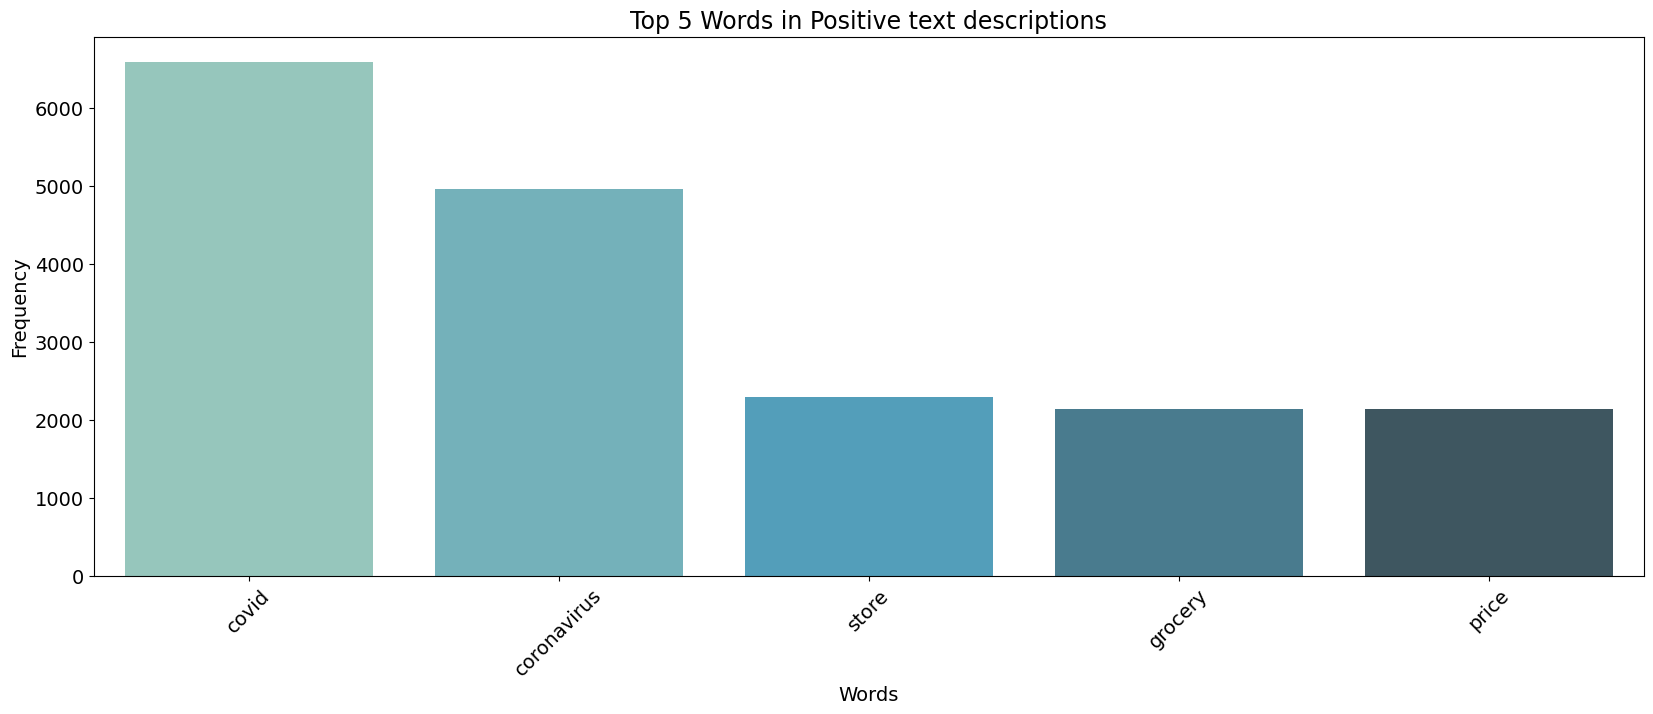

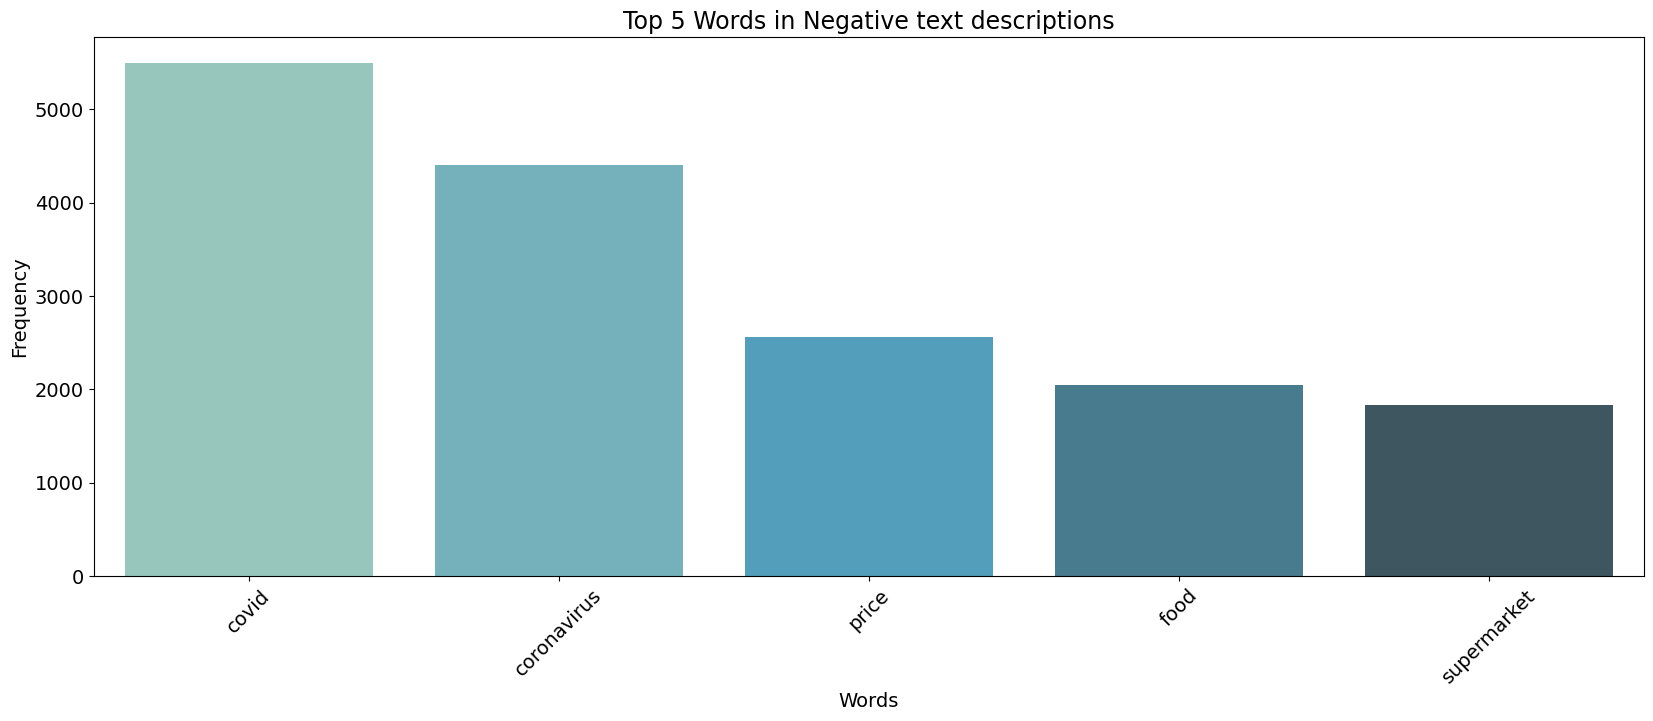

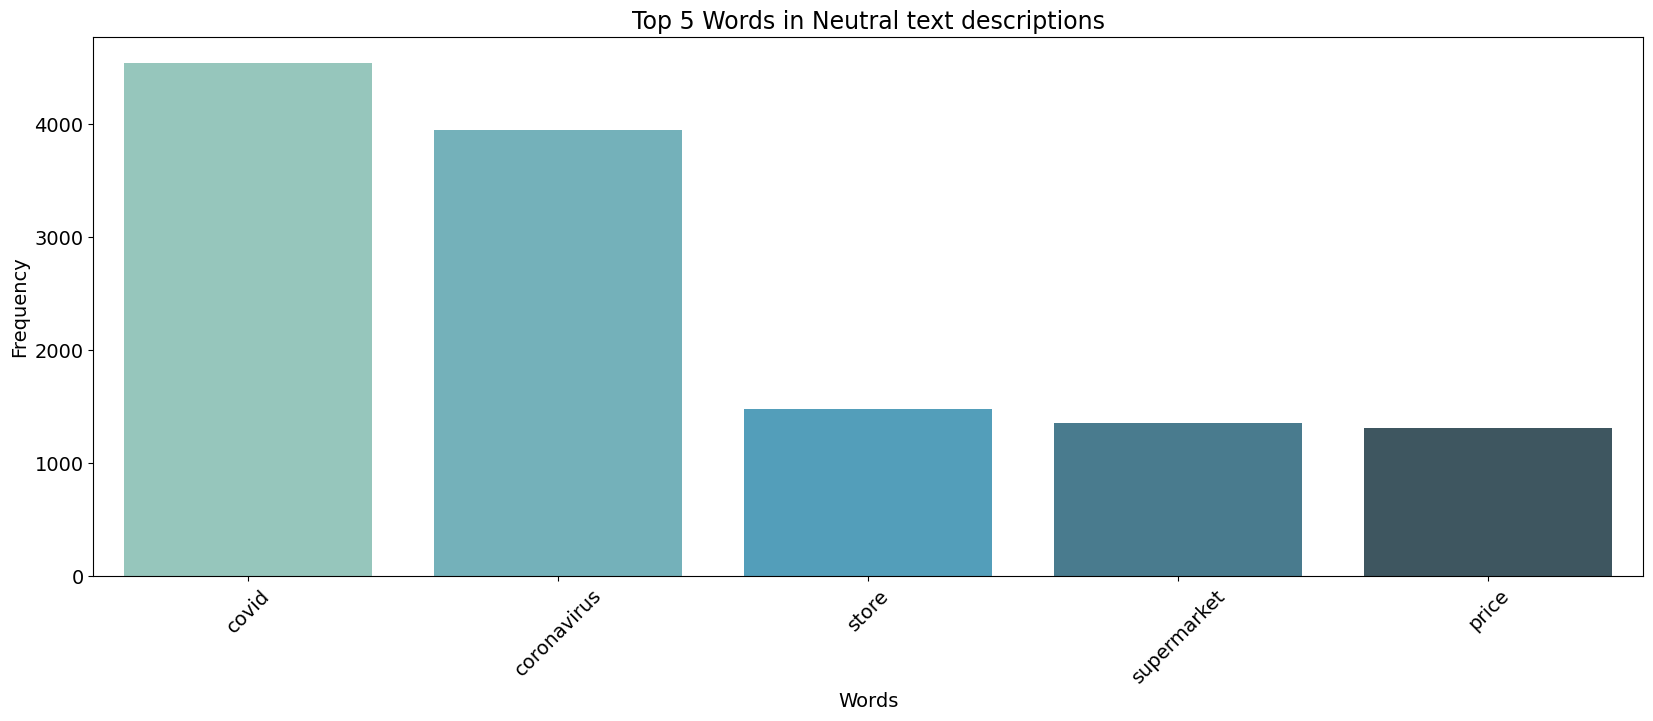

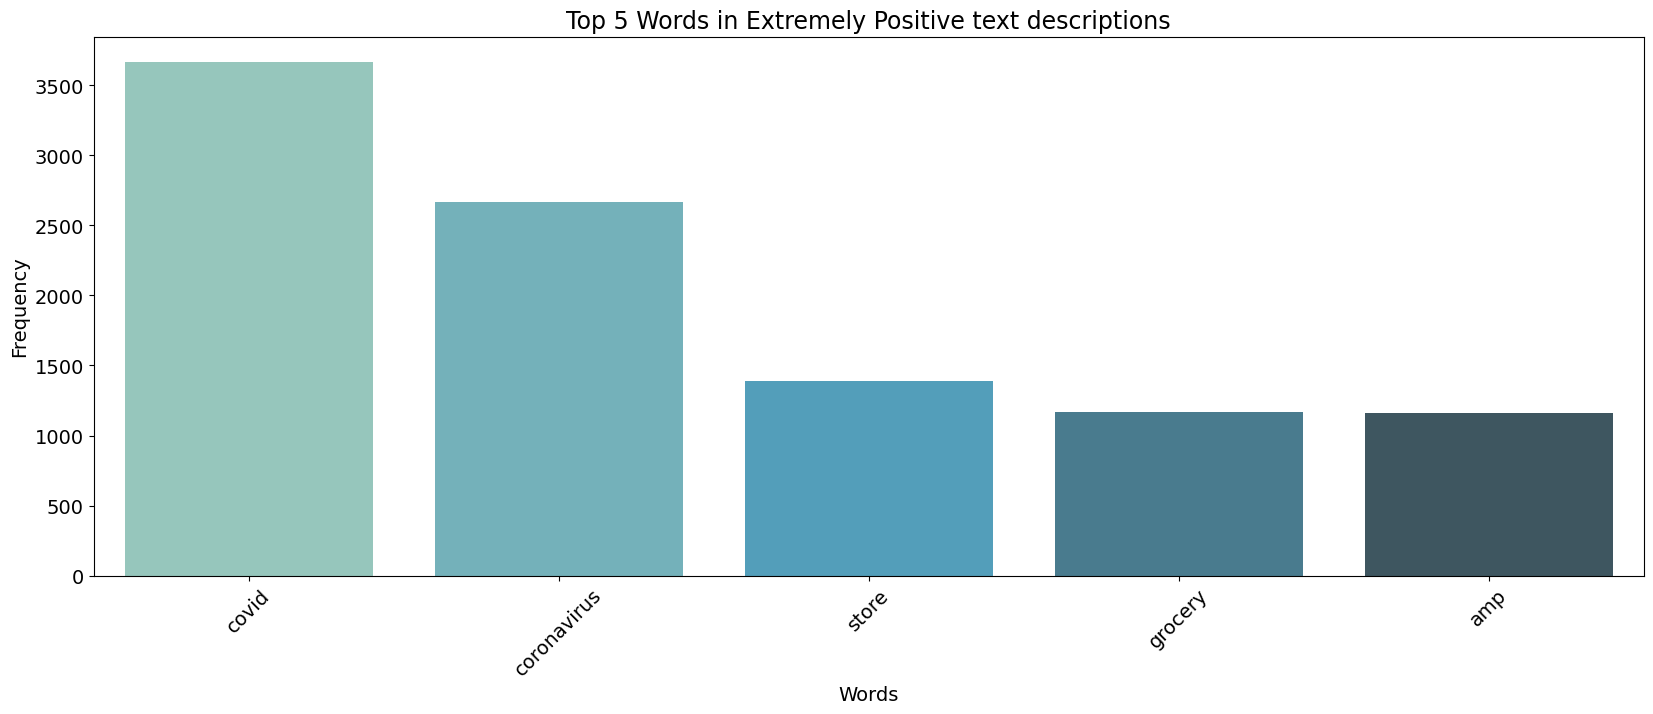

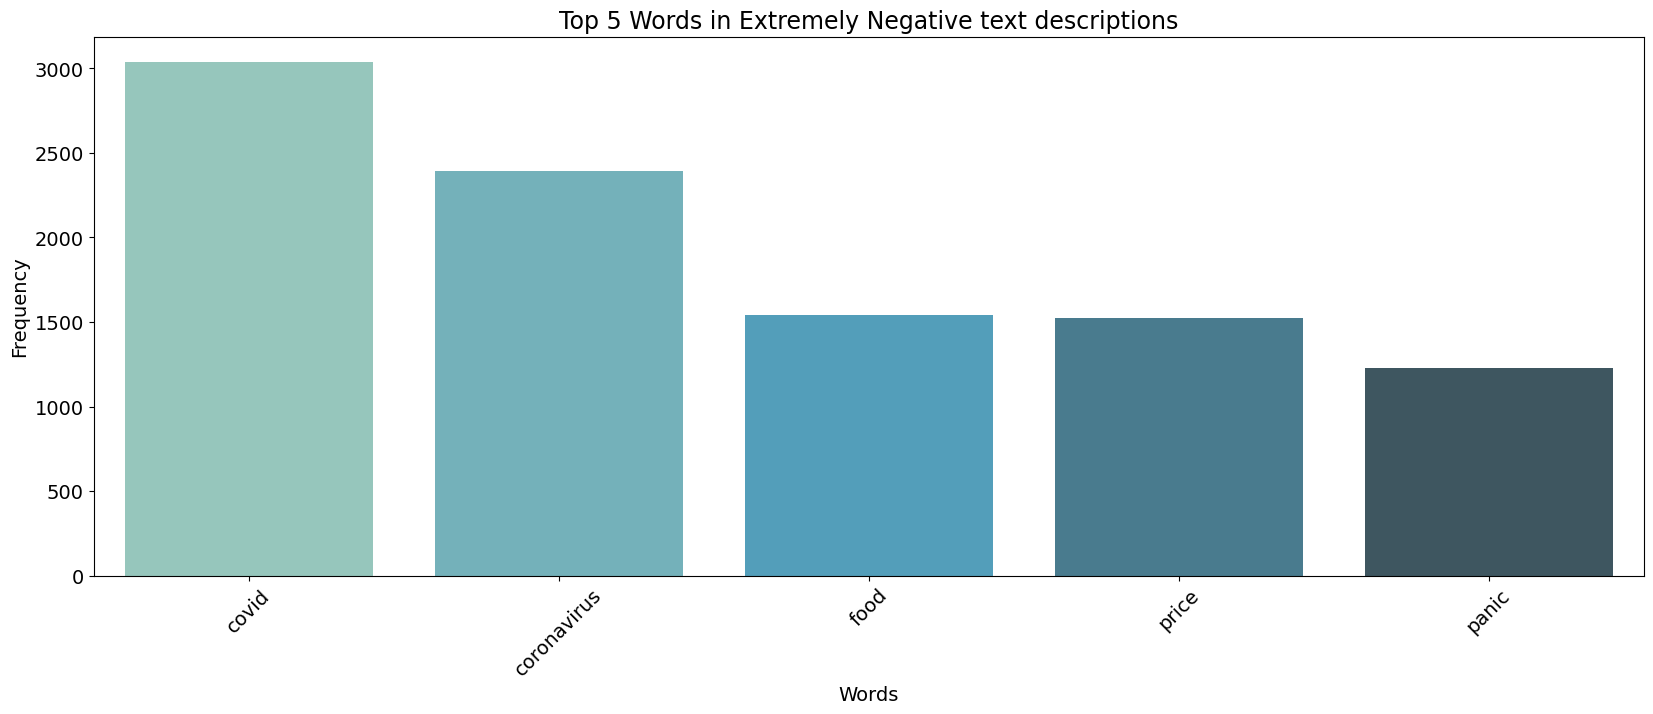

In [29]:
popular_words_by_sentiment(top_5_pos, "Positive")
popular_words_by_sentiment(top_5_neg, "Negative")
popular_words_by_sentiment(top_5_neu, "Neutral")
popular_words_by_sentiment(top_5_ex_pos, "Extremely Positive")
popular_words_by_sentiment(top_5_ex_neg, "Extremely Negative")

Here are the top 5 words by frequency among all the descriptions by Sentiment feature after text preprocessing. As you can see some of the words are used in all descriptions and it doesn't matter what kind of sentiment:

* **Positive**: ‘covid’, ‘coronavirus', ‘store’, 'grocery', 'price'
* **Negative**: ‘covid’, ‘coronavirus', 'price', 'food', 'supermarket'
* **Neutral**: ‘covid’, ‘coronavirus', ‘store’, 'supermarket', 'price'
* **Extremely Positive**: ‘covid’, ‘coronavirus', ‘store’, 'grocery', 'amp'
* **Extremely Negative**: ‘covid’, ‘coronavirus', ‘food’, 'price', 'panic'

By the way, as for me all of these words look like general - without any sentiment level. Except of the word *panic* in Extremely Negative text examples.

The next step after text preprocessing stage: model selection

***

# 2.4 Text preprocessing: Language Detector

As you can see, some of the examples are not in English. It could create a problem at the model training stage.

`*How can I resolve it in future?*`

* I can check text descriptions manually
* But it will be better to use NLP tool as Language Detector.

*Information link [https://www.johnsnowlabs.com/how-to-detect-languages-with-python-a-comprehensive-guide/]*

In [30]:
%%capture
!pip install spark-nlp
!pip install pyspark

In [31]:
%%capture
"""
simply import the library and start a Spark session
"""
import sparknlp
# Start Spark Session
spark = sparknlp.start(gpu = True) # for GPU training >> sparknlp.start(gpu = True) # for Spark 2.3 =>> sparknlp.start(spark23 = True)

import pyspark.sql.functions as F
from sparknlp.annotator import * #(LanguageDetectorDL)
from sparknlp.base import * #DocumentAssembler, Pipeline

print("Spark version:", spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp-gpu_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-fd20630e-ba7c-4df4-863e-41f3fdf9c245;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp-gpu_2.12;5.3.2 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in central
	fou

In [32]:
# Step 1: Transforms raw texts to `document` annotation
document_assembler = (
    DocumentAssembler()
    .setInputCol("text")
    .setOutputCol("document")
)

# Step 2: Determines the language of the text
languageDetector = (
    LanguageDetectorDL.pretrained()
    .setInputCols("document")
    .setOutputCol("language")
)

nlpPipeline = Pipeline(stages=[document_assembler, languageDetector])

ld_wiki_tatoeba_cnn_21 download started this may take some time.
Approximate size to download 7.1 MB
[ | ]ld_wiki_tatoeba_cnn_21 download started this may take some time.
Approximate size to download 7.1 MB
[ / ]Download done! Loading the resource.
[ / ]

[OK!]


In [33]:
# Let's look at the example:
# Create a dataframe from the sample texts in different languages
data = spark.createDataFrame([
    ["Spark NLP is an open-source text processing library for advanced natural language processing for the Python, Java and Scala programming languages."],
    ["Spark NLP est une bibliothèque de traitement de texte open source pour le traitement avancé du langage naturel pour les langages de programmation Python, Java et Scala."],
    ["Spark NLP ist eine Open-Source-Textverarbeitungsbibliothek für fortgeschrittene natürliche Sprachverarbeitung für die Programmiersprachen Python, Java und Scala."],
    ["Spark NLP es una biblioteca de procesamiento de texto de código abierto para el procesamiento avanzado de lenguaje natural para los lenguajes de programación Python, Java y Scala."],
    ["Spark NLP é uma biblioteca de processamento de texto de código aberto para processamento avançado de linguagem natural para as linguagens de programação Python, Java e Scala"]
]).toDF("text")

data

DataFrame[text: string]

In [34]:
result_ex = nlpPipeline.fit(data).transform(data)
result_ex.select("text", "language.result").show(truncate=100)

+----------------------------------------------------------------------------------------------------+------+
|                                                                                                text|result|
+----------------------------------------------------------------------------------------------------+------+
|Spark NLP is an open-source text processing library for advanced natural language processing for ...|  [en]|
|Spark NLP est une bibliothèque de traitement de texte open source pour le traitement avancé du la...|  [fr]|
|Spark NLP ist eine Open-Source-Textverarbeitungsbibliothek für fortgeschrittene natürliche Sprach...|  [de]|
|Spark NLP es una biblioteca de procesamiento de texto de código abierto para el procesamiento ava...|  [es]|
|Spark NLP é uma biblioteca de processamento de texto de código aberto para processamento avançado...|  [pt]|
+----------------------------------------------------------------------------------------------------+------+



In [35]:
"""
Let's look how does it work on our data
"""
# Getting text descriptions
train_text = df_temp[["full_desc_lem"]].values

# Create Spark DF
train_text_spark = spark.createDataFrame(train_text).toDF("text")

In [36]:
result_train = nlpPipeline.fit(train_text_spark).transform(train_text_spark)

In [37]:
result_train.printSchema()

root
 |-- text: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true

In [38]:
result_train.select("text", "language.result").show(truncate=50)

24/03/25 08:56:35 WARN TaskSetManager: Stage 5 contains a task of very large size (1424 KiB). The maximum recommended task size is 1000 KiB.


+--------------------------------------------------+------+
|                                              text|result|
+--------------------------------------------------+------+
|                        nyrbie phil gahan chrisitv|  [en]|
|advice talk neighbour family exchange phone num...|  [en]|
|coronavirus australia woolworth give elderly di...|  [en]|
|food stock one empty... please panic enough foo...|  [en]|
|ready go supermarket covid outbreak. paranoid f...|  [en]|
|news region first confirmed covid case came sul...|  [en]|
|cashier grocery store sharing insight covid pro...|  [en]|
|supermarket today. buy toilet paper. rebel toil...|  [en]|
|due covid retail store classroom atlanta open w...|  [en]|
|corona prevention stop buy thing cash use onlin...|  [en]|
|month crowding supermarket restaurant however r...|  [en]|
|due covid situation increased demand food produ...|  [en]|
|horningsea caring community. let look le capabl...|  [en]|
|need stock food amazon deliver whatever

In [39]:
"""
Transform Spark DF -> Pandas DF
"""
result_pd_df = result_train.toPandas()

24/03/25 08:56:36 WARN TaskSetManager: Stage 6 contains a task of very large size (1424 KiB). The maximum recommended task size is 1000 KiB.


In [40]:
result_pd_df.head()

,text,document,language
0,nyrbie phil gahan chrisitv,"[(document, 0, 25, nyrbie phil gahan chrisitv,...","[(language, 0, 25, en, {'sentence': '0', 'de':..."
1,advice talk neighbour family exchange phone nu...,"[(document, 0, 184, advice talk neighbour fami...","[(language, 0, 184, en, {'sentence': '0', 'de'..."
2,coronavirus australia woolworth give elderly d...,"[(document, 0, 96, coronavirus australia woolw...","[(language, 0, 96, en, {'sentence': '0', 'de':..."
3,food stock one empty... please panic enough fo...,"[(document, 0, 173, food stock one empty... pl...","[(language, 0, 173, en, {'sentence': '0', 'de'..."
4,ready go supermarket covid outbreak. paranoid ...,"[(document, 0, 186, ready go supermarket covid...","[(language, 0, 186, en, {'sentence': '0', 'de'..."


In [41]:
# Look at the predicted language
result_pd_df["predicted_language"] = result_pd_df["language"].apply(lambda x: x[0][3])
result_pd_df.head()

,text,document,language,predicted_language
0,nyrbie phil gahan chrisitv,"[(document, 0, 25, nyrbie phil gahan chrisitv,...","[(language, 0, 25, en, {'sentence': '0', 'de':...",en
1,advice talk neighbour family exchange phone nu...,"[(document, 0, 184, advice talk neighbour fami...","[(language, 0, 184, en, {'sentence': '0', 'de'...",en
2,coronavirus australia woolworth give elderly d...,"[(document, 0, 96, coronavirus australia woolw...","[(language, 0, 96, en, {'sentence': '0', 'de':...",en
3,food stock one empty... please panic enough fo...,"[(document, 0, 173, food stock one empty... pl...","[(language, 0, 173, en, {'sentence': '0', 'de'...",en
4,ready go supermarket covid outbreak. paranoid ...,"[(document, 0, 186, ready go supermarket covid...","[(language, 0, 186, en, {'sentence': '0', 'de'...",en


In [42]:
result_pd_df["predicted_language"].value_counts(normalize=True)

predicted_language
en         0.943707
da         0.015848
sl         0.014170
it         0.005153
sv         0.003816
et         0.003573
fr         0.003233
de         0.002771
lt         0.001604
nl         0.001118
pl         0.000826
pt         0.000778
sk         0.000778
es         0.000681
fi         0.000583
cs         0.000559
ro         0.000535
Unknown    0.000194
hu         0.000073
Name: proportion, dtype: float64

In [43]:
result_pd_df[result_pd_df["predicted_language"] == "Unknown"]

,text,document,language,predicted_language
5313,toilet paper handle pasta ok...but custard cre...,"[(document, 0, 70, toilet paper handle pasta o...","[(language, 0, 70, Unknown, {'sentence': '0', ...",Unknown
5722,consumer energy drop four dimension amid covid...,"[(document, 0, 55, consumer energy drop four d...","[(language, 0, 55, Unknown, {'sentence': '0', ...",Unknown
7323,coronavirus mooc coronavirus scam ftc ftc cons...,"[(document, 0, 119, coronavirus mooc coronavir...","[(language, 0, 119, Unknown, {'sentence': '0',...",Unknown
9445,panicbuying local co op. toiletroll knob get c...,"[(document, 0, 172, panicbuying local co op. t...","[(language, 0, 172, Unknown, {'sentence': '0',...",Unknown
12509,enough toiletpaper coronapocalypse coronavirus...,"[(document, 0, 119, enough toiletpaper coronap...","[(language, 0, 119, Unknown, {'sentence': '0',...",Unknown
20206,lady tramp remake. facebook instagram toiletpa...,"[(document, 0, 205, lady tramp remake. faceboo...","[(language, 0, 205, Unknown, {'sentence': '0',...",Unknown
23135,jess rudd normanswan abc sell toiletpaper milk...,"[(document, 0, 149, jess rudd normanswan abc s...","[(language, 0, 149, Unknown, {'sentence': '0',...",Unknown
37513,drfahrettinkoca zley n zzzz antalya da ya ayan...,"[(document, 0, 188, drfahrettinkoca zley n zzz...","[(language, 0, 188, Unknown, {'sentence': '0',...",Unknown


In [44]:
result_pd_df[result_pd_df["predicted_language"] == "hu"]

,text,document,language,predicted_language
9444,spot meat aldi,"[(document, 0, 13, spot meat aldi, {'sentence'...","[(language, 0, 13, hu, {'sentence': '0', 'de':...",hu
12242,supermarket,"[(document, 0, 10, supermarket, {'sentence': '...","[(language, 0, 10, hu, {'sentence': '0', 'de':...",hu
17742,ntsa kenya moh kenya npsofficial ke route keny...,"[(document, 0, 185, ntsa kenya moh kenya npsof...","[(language, 0, 185, hu, {'sentence': '0', 'de'...",hu


**Some observations:**
* About 94% of text examples are predicted as English
* Other predicted languages: Italian, French, Hungarian, etc. (da, sl, it, sv, et, fr, de, lt, nl, pl, pt, sk, es, fi, cs, ro, hu, Unknown)
* As you can see the text examples are predicted as "Unknown" are close to english too.
* Other language: Text description with 3-5 words also close to english. Maybe it has a sense to remove only examples which were predicted as Other languages with more than 10 words.


At this project I don't delete examples predicted as Other language.
Maybe I need to find better tool for language detection

***

# 3. RNN model

Recurrent neural networks (RNNs) are a specific kind of artificial neural network created to work with sequential data. It is utilized particularly in activities involving NLP, such as language translation, speech recognition, sentiment analysis, natural language generation, and summary writing. RNNs are uniquely able to capture sequential dependencies in data, which sets them apart from standard feedforward networks and makes them ideal for processing and comprehending sequential information, like language.

But anyway RNNs also face some challenges, such as:
- vanishing or exploding gradients,
- overfitting,
- long training times.

**Architecture types**

RNNs come in different variants, such as simple RNNs, long short-term memory (LSTM), gated recurrent units (GRU), and bidirectional RNNs. Each of them has its own advantages and disadvantages, depending on the task and the data.
* Simple RNNs are easy to implement, but they suffer from vanishing gradients, which means they cannot learn long-term dependencies.
* LSTM and GRU are more complex, but they have mechanisms to overcome vanishing gradients and capture longer sequences.
* Bidirectional RNNs can process data from both directions, which can improve accuracy for tasks like sentiment analysis or machine translation. 

**Model Regularization**

RNNs are prone to overfitting, which means they memorize the training data and perform poorly on new or unseen data. To prevent overfitting, you can apply some regularization techniques:
- Dropout is a method that randomly drops out some units or connections in the network during training, which reduces the complexity and co-dependency of the model
- Weight decay is a method that adds a penalty term to the loss function, which shrinks the weights and prevents them from becoming too large.
- Early stopping is a method that monitors the validation error and stops the training when it stops decreasing or starts increasing, which avoids overfitting to the training data.

**Hyperparameters**

RNNs have many hyperparameters:
- number of hidden units,
- learning rate,
- batch size,
- sequence length,
- activation function.

These hyperparameters affect the accuracy and performance of the model, but they are not easy to tune manually.

**Data preprocessing**

RNNs require clean and consistent data to learn effectively, so it's important to preprocess the data before feeding it to the model. This preprocessing can involve:
- Tokenizing splits the data into smaller units like words, characters, or subwords
- Normalizing converts the data into a standard form like lowercasing or removing punctuation
- Encoding transforms the data into numerical values such as one-hot encoding or word embedding.
- Padding adds zeros or special tokens to make the data have the same length.
- Shuffling randomizes the order of the data to avoid bias or correlation.


This information from the article [https://www.linkedin.com/advice/1/how-can-you-improve-rnn-accuracy-skills-machine-learning-y8lge]

In [30]:
"""
Previously I want to check total number of unique words after text preprocessing
-> to form NUM_WORDS global variable for model training stage
"""
df_temp["token_by_words"] = df_temp["text_lower"].apply(lambda x: x.split())

list_of_words = []

for example in df_temp["token_by_words"]:
    for word in example:
        list_of_words.append(word)
    
len(set(list_of_words))

86123

In [31]:
"""
Get final dataset with 3 columns
"""
cols = list(["Text"]+["Sentiment"]+["full_desc_lem"])

train_final = df_temp[cols]
train_final.columns = ["Text", "Sentiment", "full_desc_lem"]
display(train_final.head(2))

print(train_final.shape)

,Text,Sentiment,full_desc_lem
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,nyrbie phil gahan chrisitv
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbour family exchange phone nu...


(41142, 3)


***

In [32]:
# Global variables for model training stage
BATCH_SIZE = 64 # batch size should be larger than the number of classes
NUM_CLASSES = 5
NUM_WORDS = 100_000
EMBEDDING_VECTOR_LENGTH = 48 #text_length

In [33]:
"""
ROC curve plot by classes
"""
def roc_curve_plot(n_classes, y_val, pred_test):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw=2
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val[:, i], pred_test[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        colors = cycle(['r','b','m','g', 'y'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    
    return plt.show()

In [34]:
"""
Plot training and validation accuracy
"""
def plot_acc(history_model):
    plt.plot(history_model.history["accuracy"],
             label="train")
    
    plt.plot(history_model.history["val_accuracy"],
             label="validation")
    
    plt.xlabel("Epoch")
    plt.ylabel("Correct answers")
    plt.legend()
    
    return plt.show()

In [35]:
"""
Split out train_data to train and valid
"""
X_train, X_val, y_train, y_val = train_test_split(
    train_final.full_desc_lem,
    train_final.Sentiment,
    stratify=train_final.Sentiment, 
    test_size=0.2,
    random_state=RANDOM_SEED,
    shuffle=True)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((32913,), (8229,), (32913,), (8229,))

In [36]:
print(X_train[:4], "\n"*2,  y_train[:4])

14733    covid hit world drop price dropping price clas...
37000    consumer thought knew gone. join next webinar ...
22553    corona virus update coronavirus while u keep w...
28085    america adopted mask wearing greater vengeance...
Name: full_desc_lem, dtype: object 

 14733              Negative
37000               Neutral
22553    Extremely Positive
28085              Positive
Name: Sentiment, dtype: object


In [37]:
# encode Sentiments
ohe = OneHotEncoder()
y_train = ohe.fit_transform(np.array([[el] for el in y_train]))
y_train = y_train.toarray()

y_val = ohe.transform(np.array([[el] for el in y_val]))
y_val = y_val.toarray()

In [38]:
"""
Using keras tokenizer here

Tokenization

In an RNN we input a sentence word by word.
We represent every word as one hot vectors of dimensions: Numbers of words in Vocab +1.

What keras Tokenizer does is?
It takes all the unique words in the corpus, forms a dictionary with words as keys and their number of occurences as values,
-> then sorts the dictionary in descending order of counts.
"""
# tokenization
token = Tokenizer(NUM_WORDS)
token.fit_on_texts(list(X_train) + list(X_val))

# convert texts to numeric with one lenght
X_train_seq = token.texts_to_sequences(X_train)
X_val_seq = token.texts_to_sequences(X_val)

In [39]:
# Try printing first elements of X_train_seq -> every word is represented as a digit now
X_train_seq[:1]

[[1,
  214,
  85,
  242,
  3,
  1388,
  3,
  4566,
  11697,
  5405,
  676,
  332,
  1212,
  112,
  3812,
  14414,
  201,
  18,
  109,
  112,
  2839,
  20201,
  810,
  1169,
  20202,
  10029,
  1351]]

In [40]:
"""
We will check the maximum text length, this will help us in padding later
"""
train_tokens = X_train_seq + X_val_seq

text_len=[]

for i in range(len(train_tokens)):
    text_len.append(len(train_tokens[i]))
    
max_text_len = max(text_len)

print(f"Max text len (in preprocessing text): {max_text_len}")
print("\nWord counts in full text description (train dataset): ", train_final['Text'].apply(lambda x:len(str(x).split())).max())
print("\nWord counts in full text description (test dataset): ", test_data['Text'].apply(lambda x:len(str(x).split())).max())

Max text len (in preprocessing text): 48

Word counts in full text description (train dataset):  64

Word counts in full text description (test dataset):  62


In [41]:
"""
Padding:

The code token.word_index simply gives the dictionary of vocab that keras created for us
"""
#zero pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_text_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_text_len)

word_index = token.word_index

In [42]:
random.sample(list(word_index.items()), 10)

[('kalanchoe', 41906),
 ('avg', 7297),
 ('briefing', 1640),
 ('conflicting', 18025),
 ('worklife', 16050),
 ('momentarily', 14629),
 ('martial', 9145),
 ('pity', 6718),
 ('cdfuug', 44349),
 ('studyfromhome', 35742)]

***

In [43]:
# compute classes weights
y_labels = train_final['Sentiment'].values

class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_labels),
    y = y_labels)

classes = dict(zip(np.unique(y_labels), class_weights))
class_weights= {i : class_weights[i] for i in range(5)}
classes

{'Extremely Negative': 1.5012588943623426,
 'Extremely Positive': 1.2422101449275362,
 'Negative': 0.8297267318745588,
 'Neutral': 1.0689010132501948,
 'Positive': 0.7203992295569953}

***

# 3.1 RNN models: Simple RNN

In [44]:
"""
Creating a RNN model

- The first line model.Sequential() tells that we will be building our network sequentially.
- Then Embedding layer:
* is also a layer of neurons which takes in as input the nth dimensional one hot vector of every word and converts it into 300 dimensional vector,
* it gives us word embeddings similar to word2vec.

We could have used word2vec but the embeddings layer learns during training to enhance the embeddings.
- Next: 2 SimpleRNN layers - a fully-connected RNN where the output from previous timestep is to be fed to next timestep.
- Dropout layers - that randomly drops out some units or connections in the network during training
- At last we add 5 neurons with softmax function in order to get predictions according 5 Sentiment types

We compile the model using adam optimizer
"""
model_rnn = Sequential() # initializing model
model_rnn.add(Embedding(NUM_WORDS, #len(word_index) + 1
                        300, #EMBEDDING_VECTOR_LENGTH
                        input_length=max_text_len))
# In case of a stacked(more than one layer of RNN)
# use return_sequences=True
model_rnn.add(SimpleRNN(128,
                        activation='relu',
                        return_sequences=True))
model_rnn.add(Dropout(0.3))
model_rnn.add(SimpleRNN(64,
                        activation='relu',
                        return_sequences=False))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(64,activation='relu'))
# output layer with softmax activation
model_rnn.add(Dense(5,activation='softmax'))

# printing model summary
print(model_rnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 300)           30000000  
                                                                 
 simple_rnn (SimpleRNN)      (None, 48, 128)           54912     
                                                                 
 dropout (Dropout)           (None, 48, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 5)                 3

In [45]:
# Compiling model
model_rnn.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

In [46]:
checkpoint_callback_rnn = ModelCheckpoint('best_rnn.h1',
                                          monitor='val_accuracy',
                                          save_best_only=True,
                                          verbose=1)

In [47]:
history_rnn = model_rnn.fit(X_train_pad,
                            y_train,
                            epochs=5,
                            batch_size=BATCH_SIZE,
                            class_weight=class_weights,
                            validation_data=(X_val_pad, y_val)
                           )

Epoch 1/5


I0000 00:00:1711365063.401000     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


515/515 [==============================] - 75s 136ms/step - loss: 1.3379 - accuracy: 0.3733 - val_loss: 1.0476 - val_accuracy: 0.5904
Epoch 2/5
515/515 [==============================] - 48s 92ms/step - loss: 0.8110 - accuracy: 0.6640 - val_loss: 0.8860 - val_accuracy: 0.6602
Epoch 3/5
515/515 [==============================] - 47s 90ms/step - loss: 0.5807 - accuracy: 0.7734 - val_loss: 0.8319 - val_accuracy: 0.6938
Epoch 4/5
515/515 [==============================] - 45s 88ms/step - loss: 0.4284 - accuracy: 0.8402 - val_loss: 0.9696 - val_accuracy: 0.6856
Epoch 5/5
515/515 [==============================] - 46s 90ms/step - loss: 0.3200 - accuracy: 0.8843 - val_loss: 1.0909 - val_accuracy: 0.6850


`Useful Tip: in case of a n-class classification with categorical cross entropy the loss on the first epoch should be -ln(1/n)`

* -ln(1/5) ~ 1,609
* Our model result = 1.34. Results make sense!

In [48]:
pred_rnn = model_rnn.predict(X_val_pad)

258/258 [==============================] - 3s 9ms/step


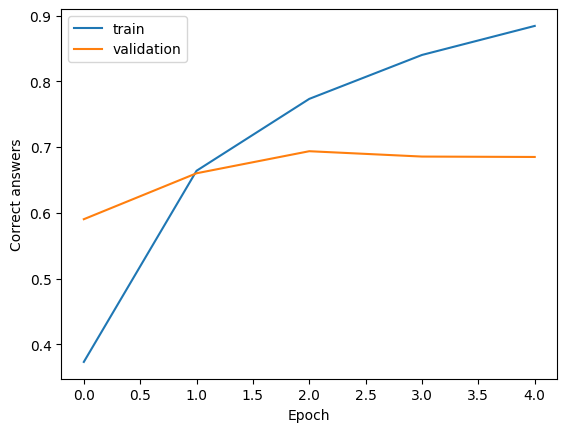

In [49]:
# plot RNN
plot_acc(history_rnn)

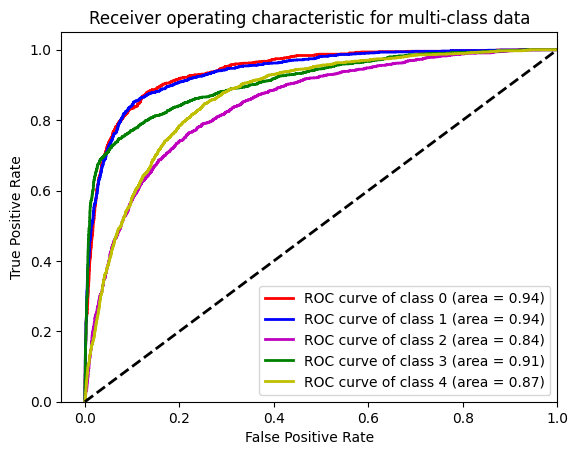

In [50]:
roc_curve_plot(NUM_CLASSES, y_val, pred_rnn)

**Area under curve of ROC vs. Accuracy**

* ROC describes the discriminative power of a classifier independent of class distribution and unequal prediction error costs (false positive and false negative cost).
* Metric like accuracy is calculated based on the class distribution.


High AUC means the model is reliably assigning higher scores (probability of positive) to positive examples than to negative examples. Accuracy could be low because the calibration (threshold) is not chosen correctly. Also AUC-ROC performs very well for imbalanced data while for balanced data Accuracy metrics perform very well.

In this case we work with imbalanced data.

In [51]:
# Printing model score on test data
print()
print("Simple RNN model Score---> ",
      model_rnn.evaluate(X_val_pad, y_val, verbose=0))


Simple RNN model Score--->  [1.0908557176589966, 0.685016393661499]


**Some observations after SimpleRNN model training:**
* Epochs number: 5
* Training data results: 
    - Accuracy: 0.88,
    - Loss: 0.32
* Validation data results:
    - Val Accuracy: 0.69,
    - Val Loss: 1.09

In total it's look like not bad. But there are some points:
- As you can see *val_loss* is increasing at the last epochs
- And the difference in *accuracy* value between training and validation data is significant

-> all of these points describe *overfitting problem*. This was the simplest model of all, we can tune a lot of hyperparameters like RNN units, we can do batch normalization, dropouts etc. to get better result.

Let's look at the other RNN's model

***

# 3.2 RNN models: LSTM

In [52]:
"""
Firstly, we need to get word embeddings.

In this Notebook, I'll be using the GloVe vectors.
"""
# load the GloVe vectors in a dictionary:
embeddings_index = {}
f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')

for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
    
f.close()

print('Found %s word vectors.' % len(embeddings_index))

0it [00:00, ?it/s]

Found 2196017 word vectors.


In [53]:
"""
We have already tokenized and paded our text for input to LSTM's
"""
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))

for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

  0%|          | 0/45505 [00:00<?, ?it/s]

In [54]:
"""
Creating LSTM with glove embeddings
(Added 2 LSTM layers + SimpleRNN layer + 2 Dense layers)
"""
model_lstm = Sequential()
model_lstm.add(Embedding(len(word_index) + 1,
                         300,
                         weights=[embedding_matrix],
                         input_length=max_text_len,
                         trainable=False))

# LSTM can return thé full séquence of vector (like a matrix) but a dense layer takes vectors as input.
model_lstm.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3, activation='relu', return_sequences=True))
model_lstm.add(LSTM(128, dropout=0.3, activation='relu', return_sequences=True))
model_lstm.add(SimpleRNN(64, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(5, activation='softmax'))
    
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 48, 300)           13651800  
                                                                 
 lstm (LSTM)                 (None, 48, 300)           721200    
                                                                 
 lstm_1 (LSTM)               (None, 48, 128)           219648    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 5)                

In [55]:
# Compiling model
model_lstm.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

In [56]:
clear_session()

In [57]:
checkpoint_callback_lstm = ModelCheckpoint('best_rnn.h2',
                                          monitor='val_accuracy',
                                          save_best_only=True,
                                          verbose=1)

In [58]:
history_lstm = model_lstm.fit(X_train_pad,
                            y_train,
                            epochs=5,
                            batch_size=BATCH_SIZE,
                            class_weight=class_weights,
                            validation_data=(X_val_pad, y_val)
                           )

Epoch 1/5
515/515 [==============================] - 130s 240ms/step - loss: 1.2002 - accuracy: 0.4535 - val_loss: 1.0617 - val_accuracy: 0.5518
Epoch 2/5
515/515 [==============================] - 122s 238ms/step - loss: 0.9599 - accuracy: 0.5756 - val_loss: 0.9524 - val_accuracy: 0.6082
Epoch 3/5
515/515 [==============================] - 123s 239ms/step - loss: 0.8676 - accuracy: 0.6249 - val_loss: 0.8860 - val_accuracy: 0.6607
Epoch 4/5
515/515 [==============================] - 123s 238ms/step - loss: 0.7955 - accuracy: 0.6589 - val_loss: 0.8299 - val_accuracy: 0.6860
Epoch 5/5
515/515 [==============================] - 122s 237ms/step - loss: 0.7375 - accuracy: 0.6879 - val_loss: 0.7932 - val_accuracy: 0.6987


In [59]:
pred_lstm = model_lstm.predict(X_val_pad)

258/258 [==============================] - 7s 26ms/step


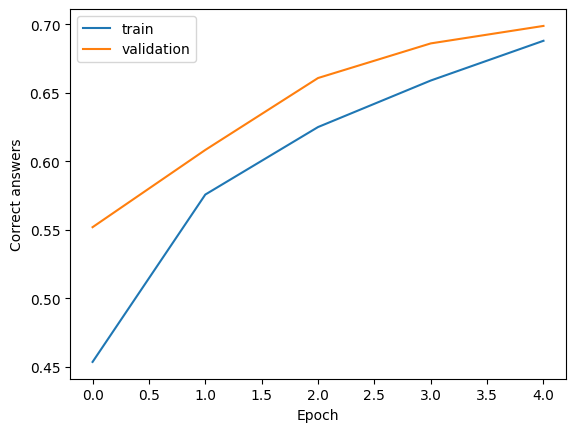

In [60]:
# plot RNN
plot_acc(history_lstm)

In [ ]:
# roc_curve_plot(NUM_CLASSES, y_val, pred_lstm)

In [61]:
# Printing model score on test data
print()
print("LSTM model Score---> ",
      model_lstm.evaluate(X_val_pad, y_val, verbose=0))


LSTM model Score--->  [0.7932299971580505, 0.6987483501434326]


**Some observations after LSTM+SimpleRNN model training:**

As a first step we calculate embedding matrix for our vocabulary from the pretrained GLoVe vectors. Then while building the embedding layer we pass Embedding Matrix as weights to the layer instead of training it over Vocabulary and thus we pass trainable = False.

* Epochs number: 5
* Training data results: 
    - Accuracy: 0.69,
    - Loss: 0.74
* Validation data results:
    - Val Accuracy: 0.7,
    - Val Loss: 0.79
    
We now see that the model is not overfitting. We see that in this case we used more complex architecture and added dropout. It prevented overfitting the data.

But we get higher validation accuracy than training accuracy at the first 2-3 epochs. This happens when use Dropout, since the behaviour when training and testing are different. When training, a percentage of the features are set to zero (20%/30% in my case since I'm using Dropout(0.2/0.3)). When testing, all features are used (and are scaled appropriately). So the model at test time is more robust - and can lead to higher testing accuracies.

Another possible reason is underfitting. Because this indicates the presence of high bias in our dataset.

***

# 3.3 RNN models: GRU

In [62]:
"""
Creating GRU with glove embeddings
(Added 2 GRU layers + SimpleRNN layer + 2 Dense layers)
"""
model_gru = Sequential()
model_gru.add(Embedding(len(word_index) + 1,
                         300,
                         weights=[embedding_matrix],
                         input_length=max_text_len,
                         trainable=False)) #True
model_gru.add(GRU(128, dropout=0.2, recurrent_dropout=0.2, activation='relu', return_sequences=True))
model_gru.add(SimpleRNN(64, activation='relu'))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dense(5, activation='softmax'))
    
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 300)           13651800  
                                                                 
 gru (GRU)                   (None, 48, 128)           165120    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 13833757 (52.77 MB)
Trainable params: 1819

In [63]:
# Compiling model
model_gru.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

In [64]:
clear_session()

In [65]:
checkpoint_callback_gru = ModelCheckpoint('best_rnn.h3',
                                          monitor='val_accuracy',
                                          save_best_only=True,
                                          verbose=1)

In [66]:
history_gru = model_gru.fit(X_train_pad,
                            y_train,
                            epochs=5,
                            batch_size=BATCH_SIZE,
                            class_weight=class_weights,
                            validation_data=(X_val_pad, y_val)
                           )

Epoch 1/5
515/515 [==============================] - 84s 155ms/step - loss: 1.2854 - accuracy: 0.3965 - val_loss: 1.0990 - val_accuracy: 0.5279
Epoch 2/5
515/515 [==============================] - 79s 154ms/step - loss: 1.0233 - accuracy: 0.5391 - val_loss: 1.0086 - val_accuracy: 0.5743
Epoch 3/5
515/515 [==============================] - 80s 156ms/step - loss: 0.9178 - accuracy: 0.5969 - val_loss: 0.9774 - val_accuracy: 0.6063
Epoch 4/5
515/515 [==============================] - 79s 154ms/step - loss: 0.8457 - accuracy: 0.6350 - val_loss: 0.9101 - val_accuracy: 0.6392
Epoch 5/5
515/515 [==============================] - 80s 156ms/step - loss: 0.7912 - accuracy: 0.6643 - val_loss: 0.8696 - val_accuracy: 0.6535


In [67]:
pred_gru = model_gru.predict(X_val_pad)

258/258 [==============================] - 5s 17ms/step


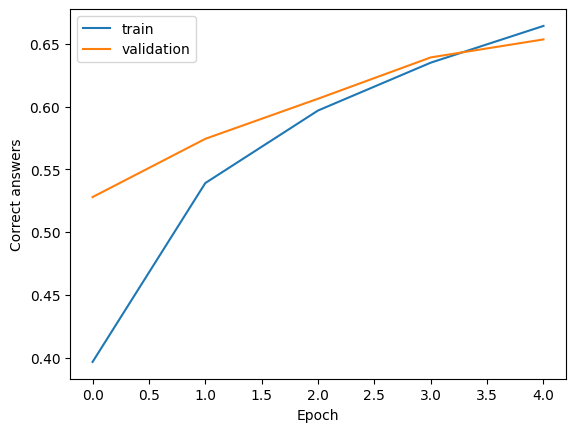

In [68]:
# plot RNN
plot_acc(history_gru)

In [ ]:
# roc_curve_plot(NUM_CLASSES, y_val, pred_gru)

In [69]:
# Printing model score on test data
print()
print("GRU model Score---> ",
      model_gru.evaluate(X_val_pad, y_val, verbose=0))


GRU model Score--->  [0.8695764541625977, 0.6535423398017883]


**Some observations after GRU model training:**

Model contains GRU layer and SimpleRNN

*I used also `trainable = True` param but val_loss has unstable value.*

* Epochs number: 5
* Training data results: 
    - Accuracy: 0.66,
    - Loss: 0.79
* Validation data results:
    - Val Accuracy: 0.65,
    - Val Loss: 0.87
    
Now we see that the model is not overfitting too, but val accuracy is less than on previosly model results. Maybe it has a sense to increase model complexity.

***

# 3.4 RNN model: Bi-Directional RNN's

In [70]:
"""
Create Bi-Directional RNN's

Only added bidirectional nature to the LSTM cells
"""
# A simple bidirectional LSTM with glove embeddings and one dense layer
model_rnn_bi = Sequential()
model_rnn_bi.add(Embedding(len(word_index) + 1,
                         300,
                         weights=[embedding_matrix],
                         input_length=max_text_len,
                         trainable=False))

model_rnn_bi.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3, activation='relu')))
model_rnn_bi.add(Dense(5, activation='softmax'))
    
model_rnn_bi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 300)           13651800  
                                                                 
 bidirectional (Bidirection  (None, 600)               1442400   
 al)                                                             
                                                                 
 dense (Dense)               (None, 5)                 3005      
                                                                 
Total params: 15097205 (57.59 MB)
Trainable params: 1445405 (5.51 MB)
Non-trainable params: 13651800 (52.08 MB)
_________________________________________________________________


In [71]:
# Compiling model
model_rnn_bi.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

In [72]:
clear_session()

In [73]:
checkpoint_callback_rnn_bi = ModelCheckpoint('best_rnn.h4',
                                          monitor='val_accuracy',
                                          save_best_only=True,
                                          verbose=1)

In [74]:
history_rnn_bi = model_rnn_bi.fit(X_train_pad,
                                  y_train,
                                  epochs=5,
                                  batch_size=BATCH_SIZE,
                                  class_weight=class_weights,
                                  validation_data=(X_val_pad, y_val)
                                 )

Epoch 1/5
515/515 [==============================] - 127s 236ms/step - loss: 1.4850 - accuracy: 0.4231 - val_loss: 1.1227 - val_accuracy: 0.5095
Epoch 2/5
515/515 [==============================] - 122s 236ms/step - loss: 1.0121 - accuracy: 0.5454 - val_loss: 1.0271 - val_accuracy: 0.5614
Epoch 3/5
515/515 [==============================] - 122s 236ms/step - loss: 0.9233 - accuracy: 0.5911 - val_loss: 0.9924 - val_accuracy: 0.5935
Epoch 4/5
515/515 [==============================] - 121s 236ms/step - loss: 0.8534 - accuracy: 0.6234 - val_loss: 0.9192 - val_accuracy: 0.6289
Epoch 5/5
515/515 [==============================] - 122s 237ms/step - loss: 0.7981 - accuracy: 0.6545 - val_loss: 0.8663 - val_accuracy: 0.6557


In [75]:
pred_rnn_bi = model_rnn_bi.predict(X_val_pad)

258/258 [==============================] - 8s 29ms/step


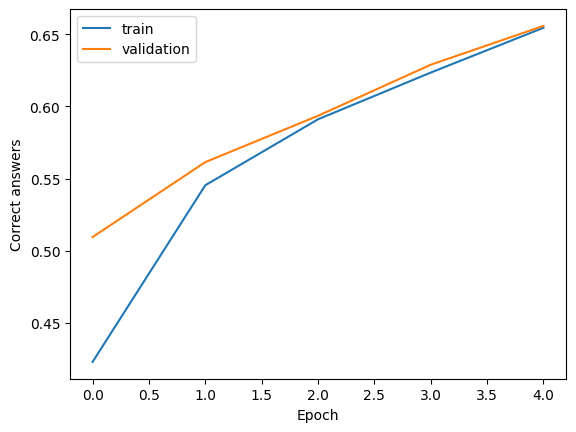

In [76]:
# plot RNN
plot_acc(history_rnn_bi)

In [ ]:
# roc_curve_plot(NUM_CLASSES, y_val, pred_rnn_bi)

In [77]:
# Printing model score on test data
print()
print("Bidirectional LSTM model Score---> ",
      model_rnn_bi.evaluate(X_val_pad, y_val, verbose=0))


Bidirectional LSTM model Score--->  [0.8662793040275574, 0.6557297110557556]


**Some observations after Bidirectional LSTM model training:**

* Epochs number: 5
* Training data results: 
    - Accuracy: 0.65,
    - Loss: 0.79
* Validation data results:
    - Val Accuracy: 0.65,
    - Val Loss: 0.87
    
Traininig and validation accuracy are increasing epoch by epoch -> we can use more epochs number, maybe it could help to increase accuracy in total.

***

In [78]:
rnn_models = pd.DataFrame({
    "Model Name": ["SimpleRNN", "LSTM", "GRU", "Bidirectional LSTM"],
    "Accuracy (train)": ["0.88", "0.69", "0.66", "0.65"],
    "Accuracy (val)": ["0.69", "0.7", "0.65", "0.65"]
})

display(rnn_models)

,Model Name,Accuracy (train),Accuracy (val)
0,SimpleRNN,0.88,0.69
1,LSTM,0.69,0.7
2,GRU,0.66,0.65
3,Bidirectional LSTM,0.65,0.65


**Some recommendations for further work:**
* Data preprocessing:
    - recheck rare words. If there are word counts less than 2 it has a sense to delete them as outliers.
    - recheck text language. If our dataset contains of examples with different languages and we use it for model training (if our task is not *translating*). After we will get model with poor predictive model. In this project I showed how it's possible to use Language Detector model.
* Text vectorization:
    - Using another type of algorithm for vectorization (word2vec - Skip-Gram or BERT from Transformers)
* NN model:
    - Hyperparameter tuning for previously discussed examples: increasing epochs number, use more complex architecture, change batch size, choose optimal optimizer with accordnig learning rate
    - Or I can use BERT Transformers which learns contextual relations between words in a sentence/text.
    

***

# 4. Submission file: test data predictions

In [79]:
X_test_seq = token.texts_to_sequences(test_data['Text'].values)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_text_len)

In [80]:
"""
LSTM model shows more stable results -> I get it for getting prediction on Test data
"""
pred_test_final = model_lstm.predict(X_test_pad)

index = np.argmax(pred_test_final, axis=1) # get index
pred_matrix = np.zeros_like(pred_test_final) # 0 matrix

pred_matrix[np.arange(len(index)), index.T] = 1 # fill 1 by index

119/119 [==============================] - 3s 26ms/step


In [81]:
ohe.inverse_transform(pred_matrix)

array([['Negative'],
       ['Positive'],
       ['Extremely Positive'],
       ...,
       ['Neutral'],
       ['Extremely Negative'],
       ['Extremely Positive']], dtype='<U18')

In [82]:
sample_submission['Sentiment'] = ohe.inverse_transform(pred_matrix)
sample_submission.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Extremely Positive
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Negative
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


***

In [83]:
# Saving result
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Extremely Positive
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Negative
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral
5,b130f7fb-7048-48e6-a8af-57bb56ac1e27,Neutral
6,db72c632-8719-4847-b7f2-a89af05e1504,Positive
7,e45239d8-4dcf-4685-a955-a9a08ca829ee,Positive
8,2854b1b2-5a41-4002-90d3-17fe77a3a78e,Extremely Negative
9,ff9be7e1-81a9-4c07-beda-4fee9a923f5e,Extremely Positive
